# Analysis with full corpus

## Initial analysis

In [1]:
import pandas as pd
import numpy as np
import praw
import datetime

In [2]:
reddit = praw.Reddit(
    client_id="iaKUGuo77BwJYHElyAo1Jg",
    client_secret="19bSH4KJpPJB2WFeYhUe--jk4IKeHQ",
    password='Ehdwn1928K!',
    user_agent="Comment Extraction u/dlehdwn",
    username='dlehdwn',
)

In [3]:
from ast import literal_eval
def converter(x):
    return literal_eval(x)

full_df = pd.read_csv('../data/full_df_processed.csv', converters={'tokens_new':converter, 'normalized_tokens':converter})

In [5]:
print(full_df.columns)

Index(['Unnamed: 0', 'id', 'parent_id', 'username', 'time_created', 'flair',
       'body', 'subreddit', 'tokens_new', 'word_count', 'normalized_tokens',
       'normalized_tokens_count', 'subreddit_name', 'sr_is_asian'],
      dtype='object')


#### Add subreddit name column

In [5]:
def get_subreddit_name(sr_id, praw_instance):
    if sr_id == 't5_2rfyw':
        return 'asianamerican'
    subreddit_lst = list(praw_instance.info(fullnames=[sr_id]))
    return subreddit_lst[0].display_name

In [6]:
print(full_df.columns)

Index(['Unnamed: 0', 'id', 'parent_id', 'username', 'time_created', 'flair',
       'body', 'subreddit', 'tokens_new', 'word_count', 'normalized_tokens',
       'normalized_tokens_count', 'subreddit_name'],
      dtype='object')


In [7]:
sr_id = full_df['subreddit']
sr_id_not_aa = (sr_id[sr_id != 't5_2rfyw']).to_list()
print(len(sr_id_not_aa)) # 1127 sr ids not asianamerican

# feed in array to praw instance
sr_lst = list(reddit.info(fullnames=sr_id_not_aa))

# list to hold subreddit names for posts/comments not of asianamericans
sr_name_lst = []

for item in sr_lst:
    sr_name_lst.append(item.display_name)

1127


KeyboardInterrupt: 

In [30]:
print(full_df.shape[0] - len(sr_name_lst))

3393


In [31]:
print(len(sr_name_lst))

# concatenate asianamerican name with sr_name_lst
num_rows = full_df.shape[0]
num_aa_rows = num_rows - len(sr_name_lst)
aa_name = ['asianamerican']*num_aa_rows

sr_name_lst_full = aa_name + sr_name_lst
print(sr_name_lst_full[3370:3400])

1127
['asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'asianamerican', 'fivethirtyeight', 'politics', 'bayarea', 'Eelam', 'MBA', 'changemyview', 'centrist']


In [32]:
print(len(sr_name_lst_full))

4520


In [33]:
full_df['subreddit_name'] = sr_name_lst_full

Drop "Unnamed: 0" column and save as csv file.

In [34]:
full_df.drop(columns=['Unnamed: 0'], inplace=True)

In [37]:
full_df.to_csv('../data/full_df_processed.csv')

### What other subreddits than r/asianamerican?

In [8]:
subreddit_counts = full_df.subreddit.value_counts().rename_axis('subreddit_id').reset_index(name='count')
subreddit_counts['subreddit'] = subreddit_counts['subreddit_id'].apply(lambda x: get_subreddit_name(sr_id=x, praw_instance=reddit))

In [9]:
subreddit_counts_no_aa = subreddit_counts.iloc[1:]

In [10]:
subreddit_counts_no_aa_limit_5 = subreddit_counts_no_aa[subreddit_counts_no_aa['count'] > 5] # filter out subreddits with 5 obs or less

NameError: name 'subreddit_counts_no_aa_limit_5' is not defined

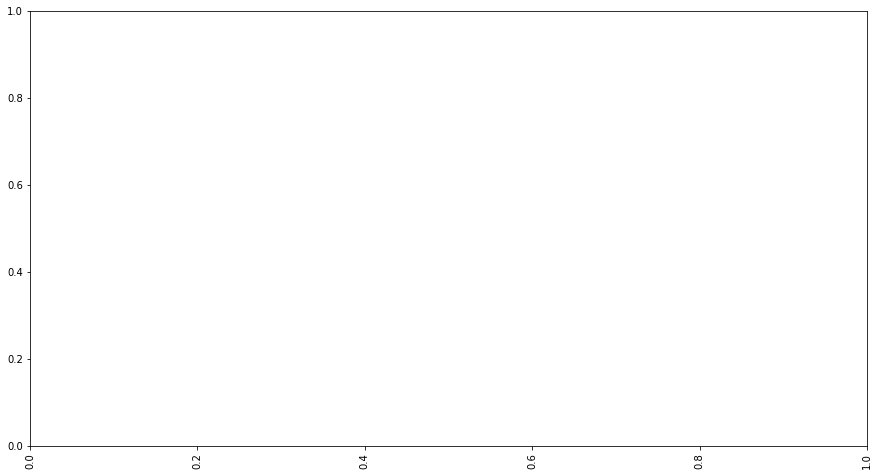

In [33]:
import matplotlib.pyplot as plt

# graph
plt.figure(figsize=(15, 8))
plt.xticks(rotation=90)
plt.bar(subreddit_counts_no_aa_limit_5['subreddit'], subreddit_counts_no_aa_limit_5['count'])
plt.title('Number of posts/comments regarding affirmative action by r/asianamerican users on subreddits other than r/asianamerican')
plt.show();

**Notes**:
- Follow-up question: How many users have posted in each of the above subreddits?
- Many of the posts/comments are in Asian-related subreddits (e.g. aznidentity, AsianMasculinity, ABCDesis, progressiveasians). This may be evidence for to the referent informational influence (social influence is exerted more strongly by ingroup vs outgroup).

In [32]:
subreddit_user_counts = full_df.groupby(['subreddit_name', 'username']).size()
#display(subreddit_user_counts)

sr_user_counts_df = subreddit_user_counts.to_frame(name='count').reset_index()
#display(sr_user_counts_df)
sr_user_counts_df.drop(columns=['count'], inplace=True)

sr_user_counts_df_final = sr_user_counts_df.groupby(['subreddit_name']).size()
sr_user_counts_arr = sr_user_counts_df_final.sort_values(ascending=False)[1:]

In [51]:
non_aa_sr_num_users = sr_user_counts_arr.to_frame(name='num_users').reset_index()

Notes:
- Users from r/asianamerican who posted/commented about affirmative action posted/commented about affirmative action in 204 other subreddits

### New research question: 
Regarding affirmative action, of r/asianamerican users who posted/commented on other subreddits, are they more likely to post/comment on other Asian-American related subreddits than other subreddits?

1. Get usernames who posted/commented on other subreddits
2. Are those subreddits Asian-related or not?
3. Is there a statistically significant difference between number of users who posted/commented on Asian-related subreddits and number of users who posted/commented on non-Asian related subreddits?

In [35]:
# get num of users who posted/commented on other subreddits
non_aa_df = full_df[full_df['subreddit_name'] != 'asianamerican']
non_aa_users = non_aa_df['username'].unique()
all_users = full_df['username'].unique()

print(f'Num of total users: {len(all_users)}')
print(f'Num of users who posted/commented on other subreddits: {len(non_aa_users)}')

Num of total users: 757
Num of users who posted/commented on other subreddits: 220


In [36]:
import re
def contains_asian(str_):
    # regex to identify any asian american group
    regex = re.compile(r'(asian?)|(korean?)|(tamil)|(eelam)|(indian)|(south asian?)|(pakistan)|(desi)|(chinese)|(china)|(japane?s?e?)|(vietn?a?m?e?s?e?)|(filipin[oa])|(philippines?)')

    return regex.search(str_)

In [51]:
# get all other subreddits
all_sr = full_df['subreddit_name'].unique()
#sr_not_2rfyw = all_sr[all_sr != 'asianamerican']

# asian boolean array
asian_bool = np.zeros(len(all_sr), dtype=bool)

# get subreddits' description, description_html, public_description
for i, sr in enumerate(all_sr):
    sr_obj = reddit.subreddit(all_sr[i])
    descr = contains_asian(sr_obj.description.lower())
    pub_desc = contains_asian(sr_obj.public_description.lower())

    # Outliers:
    should_be_asian = ['asianfeminism', 'singapore', 'taiwan', 'asianamerican']  # subreddits which should be classified as Asian
    should_not = ['blackladies'] # subreddits which should not be

    if sr in should_not:
        continue

    if sr in should_be_asian or bool(pub_desc):
        asian_bool[i] = True

In [52]:
# create dataframe of columns: subreddit_name, is_asian
is_sr_asian_dict = {'subreddit_name': all_sr, 'is_asian': asian_bool}
is_sr_asian_df = pd.DataFrame(is_sr_asian_dict)
is_sr_asian_series = is_sr_asian_df.set_index('subreddit_name')['is_asian']

is_sr_asian_series

subreddit_name
asianamerican       True
fivethirtyeight    False
politics           False
bayarea            False
Eelam               True
                   ...  
self               False
askgaybros         False
trump              False
gaybros            False
ainbow             False
Name: is_asian, Length: 205, dtype: bool

In [53]:
# see all the asian subreddits
is_sr_asian_df[is_sr_asian_df['is_asian'] == True]

,subreddit_name,is_asian
0,asianamerican,True
4,Eelam,True
11,progressiveasians,True
12,aznidentity,True
14,ABCDesis,True
18,asiantwoX,True
63,AskAChinese,True
74,AsianMasculinity,True
75,asianbros,True
89,asian,True


In [54]:
print(is_sr_asian_df[is_sr_asian_df['is_asian'] == False].to_string())

            subreddit_name  is_asian
1          fivethirtyeight     False
2                 politics     False
3                  bayarea     False
5                      MBA     False
6             changemyview     False
7                 centrist     False
8              exchristian     False
9        NoStupidQuestions     False
10         highereducation     False
13       TheMajorityReport     False
15                    UofT     False
16                Thedaily     False
17                 Harvard     False
19                Military     False
20      BlackPeopleTwitter     False
21               samharris     False
22      WhitePeopleTwitter     False
23        FinancialCareers     False
24               Economics     False
25     IntellectualDarkWeb     False
26              Republican     False
27             geopolitics     False
28              neoliberal     False
29                  scotus     False
30        moderatepolitics     False
31                    news     False
3

In [41]:
non_aa_df['sr_is_asian'] = non_aa_df['subreddit_name'].map(is_sr_asian_series)

c:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [124]:
non_aa_df.to_csv('../data/not_asianamerican_df.csv')

#### Create 'sr_is_asian' column for full_df

In [55]:
full_df['sr_is_asian'] = full_df['subreddit_name'].map(is_sr_asian_series)

In [56]:
full_df.head(5)

,id,parent_id,username,time_created,flair,body,subreddit,tokens_new,word_count,normalized_tokens,normalized_tokens_count,subreddit_name,sr_is_asian
0,14m8mf4,NaN,Tungsten_,2023-06-29 10:54:44,NaN,[Megathread] Supreme Court Ruling on Affirmati...,t5_2rfyw,"[Megathread, Supreme, Court, Ruling, on, Affir...",78,"[megathread, supreme, court, ruling, affirmati...",62,asianamerican,True
1,jq5du0z,t3_14m8mf4,Tungsten_,2023-06-30 11:33:11,NaN,Thanks to everyone who engaged in insightful a...,t5_2rfyw,"[Thanks, to, everyone, who, engaged, in, insig...",20,"[thank, engage, insightful, respectful, discou...",9,asianamerican,True
2,jq0dgzx,t3_14m8mf4,ProudBlackMatt,2023-06-29 11:16:15,Chinese-American,I would prefer using a process that takes into...,t5_2rfyw,"[I, would, prefer, using, a, process, that, ta...",103,"[prefer, process, take, account, poverty, inst...",52,asianamerican,True
3,jq0cg7k,t3_14m8mf4,TomatoCanned,2023-06-29 11:09:47,NaN,"u/Tungsten_, Thanks for creating a section jus...",t5_2rfyw,"[u/Tungsten_,, Thanks, for, creating, a, secti...",269,"[u/tungsten_,, thank, create, section, discuss...",126,asianamerican,True
4,jq0f52k,t3_14m8mf4,bad-fengshui,2023-06-29 11:26:41,NaN,As with anything related to Asians in politics...,t5_2rfyw,"[As, with, anything, related, to, Asians, in, ...",59,"[relate, asians, politic, m, see, lot, non, as...",25,asianamerican,True


In [57]:
full_df.to_csv('../data/full_df_processed.csv')

#### **Checkpoint**: May 15

In [6]:
from ast import literal_eval
def converter(x):
    return literal_eval(x)

non_aa_df = pd.read_csv('../data/not_asianamerican_df.csv', converters={'tokens_new':converter, 'normalized_tokens':converter})
#no_chinese_df = pd.read_csv('../data/comments_no_chinese_df.csv', converters={'tokens_new':converter, 'normalized_tokens':converter})

In [7]:
non_aa_df

,Unnamed: 0,id,parent_id,username,time_created,flair,body,subreddit,tokens_new,word_count,normalized_tokens,normalized_tokens_count,subreddit_name,sr_is_asian
0,3393,jqr1o69,t1_jqpgk9o,bad-fengshui,2023-07-05 12:52:29,NaN,Most do not support race-based factors in admi...,t5_2rxlz,"[Most, do, not, support, race, based, factors,...",107,"[support, race, base, factor, admission, hear,...",55,fivethirtyeight,False
1,3394,jq0qqg1,t3_14m713v,Pancake_muncher,2023-06-29 17:38:57,NaN,Apparently Affirmative action benefited white ...,t5_2cneq,"[Apparently, Affirmative, action, benefited, w...",89,"[apparently, affirmative, action, benefit, whi...",46,politics,False
2,3395,jf0anow,t1_jez4czh,suberry,2023-04-05 03:24:28,NaN,There's such an over representation of Black/L...,t5_2qjyy,"[There, 's, such, an, over, representation, of...",79,"[representation, black, latino, issue, asians,...",40,bayarea,False
3,3396,14qweh5,NaN,e9967780,2023-07-05 01:13:45,Jaffna,Prof. Thomas Sowell on Sri Lanka and failure o...,t5_2zra6,"[Prof., Thomas, Sowell, on, Sri, Lanka, and, f...",11,"[prof, thomas, sowell, sri, lanka, failure, af...",8,Eelam,True
4,3397,kx48fsg,t3_1bq08fk,e9967780,2024-03-29 14:57:30,NaN,Affirmative action for foreign born people sho...,t5_2rbd9,"[Affirmative, action, for, foreign, born, peop...",86,"[affirmative, action, foreign, bear, people, i...",47,MBA,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,4515,osjkh6,NaN,yellowmix,2021-07-27 09:32:14,NaN,This Is the End of Affirmative Action. What ar...,t5_2qhgd,"[This, Is, the, End, of, Affirmative, Action, ...",15,"[end, affirmative, action, go]",4,racism,False
1123,4516,iw0q5sn,t3_yr5o90,yellowmix,2022-11-12 01:09:36,NaN,What do you mean? That nepotism comes from whi...,t5_2qhgd,"[What, do, you, mean, That, nepotism, comes, f...",32,"[mean, nepotism, come, white, supremacy, nepot...",15,racism,False
1124,4517,uyzxgz,NaN,Kamala_Metamorph,2022-05-27 14:52:16,​,How to have a conversation with an open-minded...,t5_38jid,"[How, to, have, a, conversation, with, an, ope...",237,"[conversation, open, minded, disadvantaged, gu...",117,MensLib,False
1125,4518,l20ftbs,t3_1cfw1ru,Extension_River_9901,2024-04-30 22:56:39,New user,Democrats that want to expand education .Fun...,t5_3amv4,"[Democrats, that, want, to, expand, education,...",349,"[democrats, want, expand, education, .funding,...",197,aznidentity,True


### Amount of activity by users - Non-Asian vs Asian subreddits

1. Look at average number of "non-Asian" posts/comments.
2. Look at average number of Asian posts/comments.
3. Look for outliers.

In [6]:
non_aa_groupby = non_aa_df.groupby(['username', 'subreddit_name', 'sr_is_asian']).size()
print(type(non_aa_groupby))
max_idx = non_aa_groupby.argmax()
print(non_aa_groupby[[max_idx]])

<class 'pandas.core.series.Series'>
username  subreddit_name  sr_is_asian
wyzra     changemyview    False          114
dtype: int64


In [7]:
non_aa_groupby

username              subreddit_name       sr_is_asian
01panm                LawSchool            False          1
                      lawschooladmissions  False          5
03d8fec841cd4b826f2d  AmerExit             False          2
                      Cornell              False          2
                      NoStupidQuestions    False          1
                                                         ..
yfunk3                democrats            False          1
yogurtchicken21       SanJose              False          1
ypjogger              news                 False          2
                      survivor             False          1
                      taiwan               True           1
Length: 456, dtype: int64

In [8]:
non_aa_avg_post = non_aa_df.groupby(['sr_is_asian']).size()
non_aa_avg_post

sr_is_asian
False    837
True     290
dtype: int64

In [9]:
print(non_aa_groupby.sort_values(ascending=False).to_string()) # username: wyzra is an outlier

username              subreddit_name         sr_is_asian
wyzra                 changemyview           False          114
                      antiAA                 False           97
                      politics               False           22
                      AskALiberal            False           20
                      aznidentity            True            18
usaar33               California_Politics    False           16
wildgift              progressiveasians      True            16
BlackSuperSonic       changemyview           False           15
masamunexs            aznidentity            True            15
usaar33               AskALiberal            False           14
wyzra                 AsianMasculinity       True            12
foxcnnmsnbc           AsianMasculinity       True            11
King-Peasant          aznidentity            True            11
jacksnyder2           neoliberal             False           10
wyzra                 neoliberal             Fa

### How many users posted/commented on only Asian subreddits? On only non-Asian subreddits? On both?

In [10]:
non_aa_only = non_aa_df.groupby(['username', 'sr_is_asian']).size()
print(non_aa_only.to_string())

non_aa_only_df= non_aa_only.to_frame(name='count').reset_index()
non_aa_only_df.drop(columns=['count'], inplace=True)
non_aa_only_df

#print(non_aa_only.sort_values(ascending=False).to_string())

username              sr_is_asian
01panm                False            6
03d8fec841cd4b826f2d  False           11
ATWiggin              False            1
Abc1986               True            10
Admiral_Wen           False            2
                      True             1
Amosqu                True             5
AnimeCiety            False           17
AriChow               False            1
AwesomeAsian          False            1
Babycorgz             False            1
Barebacking_Bernanke  False            2
Bestrafen             False            1
BlackSuperSonic       False           39
Boardatworck          False            1
ButRickSaid           False            4
Canadian_propaganda   False            1
Cinnabar-Chan         False            1
ClayTart              False            9
Colt459               False            4
Dimeron               False            1
                      True             1
Due-Somewhere5639     False            7
Edge-master           F

,username,sr_is_asian
0,01panm,False
1,03d8fec841cd4b826f2d,False
2,ATWiggin,False
3,Abc1986,True
4,Admiral_Wen,False
...,...,...
245,yellowmix,False
246,yfunk3,False
247,yogurtchicken21,False
248,ypjogger,False


In [11]:
# users with posts/comments in non-Asian sr
users_false = list(non_aa_only_df[non_aa_only_df['sr_is_asian'] == False]['username'])
# users with posts/comments in Asian sr
users_true = list(non_aa_only_df[non_aa_only_df['sr_is_asian'] == True]['username'])

# users with posts/comments in both
users_both = list(set(users_false).intersection(set(users_true)))
#print(len(users_both))

# users with only non-Asian
users_only_false = list(set(users_false).difference(set(users_both)))

# users with only Asian
users_only_true = list(set(users_true).difference(set(users_both)))

all_users = users_only_true + users_false
print(len(all_users))

print(f'Num of users with only non-Asian subreddit interaction: {len(users_only_false)}')
print(f'Num of users with only Asian subreddit interaction: {len(users_only_true)}')
print(f'Num of users with both non-Asian and Asian: {len(users_both)}')

220
Num of users with only non-Asian subreddit interaction: 134
Num of users with only Asian subreddit interaction: 56
Num of users with both non-Asian and Asian: 30


Of 220 users who posted/commented on other subreddits:
- 56 users only interacted within Asian-centric subreddits
- 134 users only interacted with non-Asian related subreddits (keep in mind that r/asianamerican is a Asian-centric subreddit)
- 30 users interacted with both Asian and non-Asian related subreddits

Also,
- Most users (537 of 757 total users) only discussed affirmative action in r/asianamerican.
- Of users who also discussed affirmative action on other subreddits (220 users), 164 users discussed it in non-Asian subreddits. 

In relation to the referent information influence among Asian Americans' support for affirmative action in Alt & Goh (2024), we see some evidence in this theory being valid in the Reddit context as most users did not discuss affirmative action in other non-Asian subreddits. However, most users did not discuss affirmative action in other subreddits at all. Of the 220 users who did discuss affirmative action in other subreddits, a large majority (164 users) discussed in non-Asian related subreddits.

### Visuals

In [12]:
import matplotlib.pyplot as plt

#### Num of active users by subreddit type

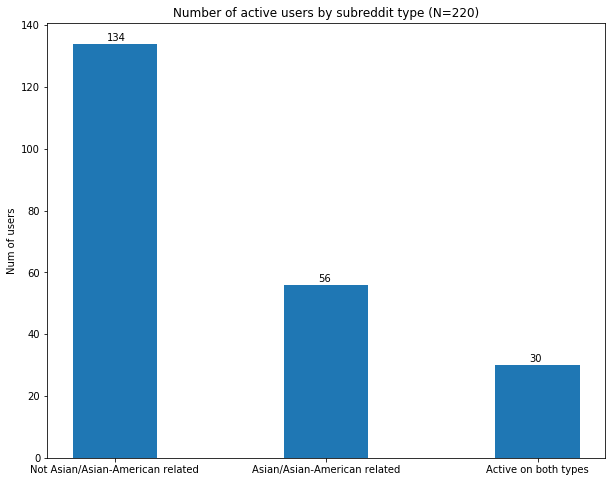

In [13]:
xlabels = ['Not Asian/Asian-American related', 'Asian/Asian-American related', 'Active on both types']
y_vals = [len(users_only_false), len(users_only_true), len(users_both)]

# graph
plt.figure(figsize=(10, 8))
#plt.xticks(rotation=90)
plt.bar(xlabels, y_vals, width = 0.4)
plt.title('Number of active users by subreddit type (N=220)')
plt.ylabel('Num of users')

# show bar values
for i, v in enumerate(y_vals):
    plt.text(i-0.04, v+1, str(y_vals[i]))

plt.show();

#### Num of posts/comments by subreddit type

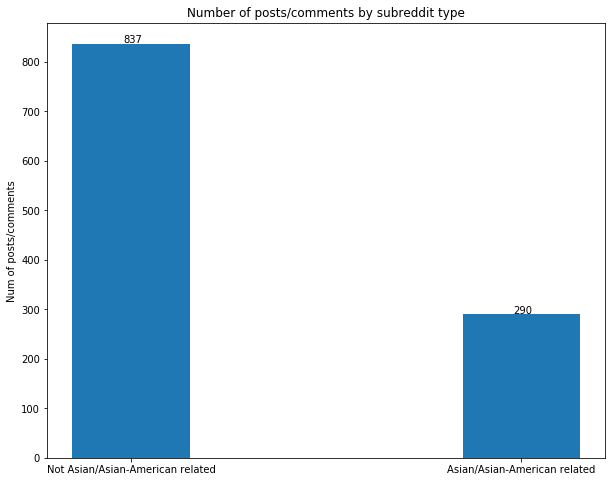

In [14]:
import matplotlib.pyplot as plt

non_asian_nrows = (non_aa_df['sr_is_asian'] == False).sum()
asian_nrows = (non_aa_df['sr_is_asian'] == True).sum()
y_vals = [non_asian_nrows, asian_nrows]

xlabels = ['Not Asian/Asian-American related', 'Asian/Asian-American related']

# graph
plt.figure(figsize=(10, 8))
#plt.xticks(rotation=90)
plt.bar(xlabels, y_vals, width = 0.3)
plt.title('Number of posts/comments by subreddit type')
plt.ylabel('Num of posts/comments')

# show bar values
for i, v in enumerate(y_vals):
    plt.text(i-0.02, v+1, str(y_vals[i]))

plt.show();


#### Num of subreddits by type

In [15]:
non_aa_groupby_sr = non_aa_df.groupby(['subreddit_name', 'sr_is_asian']).size()
non_aa_groupby_sr
non_aa_groupby_sr_df = non_aa_groupby_sr.to_frame(name='count').reset_index()
non_aa_groupby_sr_df.drop(columns=['count'], inplace=True)

print((non_aa_groupby_sr_df['sr_is_asian'] == False).sum())
print((non_aa_groupby_sr_df['sr_is_asian']).sum())

183
21


### Two proportion t-test (sample size less than 30) [Chi-squared test may be more appropriate]

**Right-tailed test**

$$H_0: p_1 = p_2$$
$$H_1: p_1 > p_2$$

- First population is users who interacted with users outside of Asian American centric or Asian-centric subreddits
- Second population is users who only interacted with users inside Asian American centric or Asian-centric subreddits

Null: First proportion is equal to the Second proportion

Alternative: First proportion is greater than the second proportion

In [16]:
from statsmodels.stats.proportion import proportions_ztest
from random import sample

In [17]:
# random sample of 22 from 220 users
sample_size = 22 # 10% of 220 total users
sample1 = sample(all_users, sample_size)
sample2 = sample(all_users, sample_size)

# count successes of each sample
success1 = len(set(users_false).intersection(set(sample1)))
success2 = len(set(users_only_true).intersection(set(sample2)))

In [18]:
counts = [success1, success2]
nobs = [sample_size, sample_size]

z_test = proportions_ztest()

TypeError: proportions_ztest() missing 2 required positional arguments: 'count' and 'nobs'

### try hypothesis test difference in means

$$H_0: \mu_1 = \mu_2$$
$$H_1: \mu_1 > \mu_2$$


In [13]:
# get num of comments and posts by each user by type of subreddit
non_aa_only = non_aa_df.groupby(['username', 'sr_is_asian']).size()
non_aa_num_comm_type = non_aa_only.to_frame(name='count').reset_index()
#print(non_aa_num_comm_type)

false_comm_counts = non_aa_num_comm_type[non_aa_num_comm_type['sr_is_asian']==False]['count']
true_comm_counts = non_aa_num_comm_type[non_aa_num_comm_type['sr_is_asian']==True]['count']

# outliers
false_comm_counts_sorted = false_comm_counts.sort_values(ascending=False)[1:]
print(true_comm_counts.sort_values(ascending=False))

'''
non_aa_num_comm_type_groupby = non_aa_num_comm_type.groupby(['sr_is_asian']).sum()
print(non_aa_num_comm_type_groupby)
num_of_comm_false = non_aa_num_comm_type_groupby['count'][0]
num_of_comm_true = non_aa_num_comm_type_groupby['count'][1]

print(f'Avg num of posts and comments by user in non-Asian {num_of_comm_false/len(users_false)}')
print(f'Avg num of posts and comments by user in non-Asian {num_of_comm_true/len(users_true)}')
'''

241    31
235    21
171    15
181    13
139    12
       ..
131     1
243     1
127     1
94      1
128     1
Name: count, Length: 86, dtype: int64


"\nnon_aa_num_comm_type_groupby = non_aa_num_comm_type.groupby(['sr_is_asian']).sum()\nprint(non_aa_num_comm_type_groupby)\nnum_of_comm_false = non_aa_num_comm_type_groupby['count'][0]\nnum_of_comm_true = non_aa_num_comm_type_groupby['count'][1]\n\nprint(f'Avg num of posts and comments by user in non-Asian {num_of_comm_false/len(users_false)}')\nprint(f'Avg num of posts and comments by user in non-Asian {num_of_comm_true/len(users_true)}')\n"

In [19]:
from scipy import stats
from statsmodels.stats.weightstats import ztest

# check observed standard deviations
std1 = np.std(false_comm_counts_sorted)
print(std1)
std2 = np.std(true_comm_counts)
print(std2)

mean1 = np.mean(false_comm_counts_sorted)
print(mean1)
mean2 = np.mean(true_comm_counts)
print(mean2)

print(stats.ttest_ind(false_comm_counts_sorted, true_comm_counts, equal_var=True, alternative='less'))
print(ztest(false_comm_counts_sorted, true_comm_counts, alternative='smaller'))


6.374401410179683
4.5953629601515384
3.2576687116564416
3.372093023255814
Ttest_indResult(statistic=-0.14687831251606698, pvalue=0.4416739413358822)
(-0.14687831251606698, 0.44161403517706904)


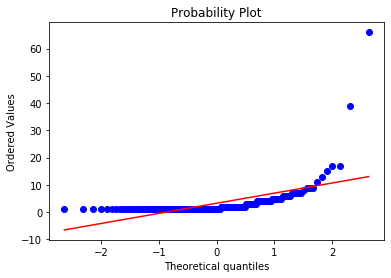

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(false_comm_counts_sorted, plot=ax)
#ax.set_title("Probplot for loggamma dist with shape parameter 2.5")

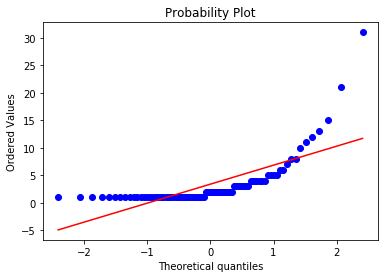

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(true_comm_counts, plot=ax)

#### **Checkpoint: May 28**

In [8]:
from ast import literal_eval
def converter(x):
    return literal_eval(x)

full_df = pd.read_csv('../data/full_df_processed.csv', converters={'tokens_new':converter, 'normalized_tokens':converter})

# csv file/df of posts and comments not scraped from r/asianamerican
non_aa_df = pd.read_csv('../data/not_asianamerican_df.csv', converters={'tokens_new':converter, 'normalized_tokens':converter})

## Differences in significant collocations

In [9]:
import nltk

In [10]:
print(non_aa_df.columns)

Index(['Unnamed: 0', 'id', 'parent_id', 'username', 'time_created', 'flair',
       'body', 'subreddit', 'tokens_new', 'word_count', 'normalized_tokens',
       'normalized_tokens_count', 'subreddit_name', 'sr_is_asian'],
      dtype='object')


### Out-group interaction collocations

In [21]:
outgroup_df = non_aa_df[non_aa_df['sr_is_asian'] == False]
outgroup_bg = nltk.collocations.BigramCollocationFinder.from_words(outgroup_df['normalized_tokens'].sum())
outgroup_bg.apply_freq_filter(3) # ignore bigrams which occur less than 3 times in corpus

In [22]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
outgroup_bgm = outgroup_bg.score_ngrams(bigram_measures.student_t)

In [24]:
outgroup_bgm

[(('affirmative', 'action'), 34.28630968680275),
 (('asian', 'americans'), 12.593378930424949),
 (('asian', 'american'), 9.247576620742509),
 (('black', 'people'), 8.82306502488384),
 (('white', 'people'), 8.05469249151948),
 (('supreme', 'court'), 8.045514967571844),
 (('asian', 'student'), 7.6166584367743),
 (('high', 'school'), 7.246053943160856),
 (('black', 'student'), 6.991614900709455),
 (('college', 'admission'), 6.843657337080807),
 (('legacy', 'admission'), 6.6750741645415586),
 (('racial', 'preference'), 6.55894330549099),
 (('race', 'base'), 6.423727401192768),
 (('white', 'student'), 6.203847673454241),
 (('action', 'policy'), 6.189773988455569),
 (('action', 'program'), 6.150423866240542),
 (('low', 'income'), 5.9716154732013065),
 (('high', 'education'), 5.731443927623531),
 (('civil', 'right'), 5.638825823280965),
 (('base', 'affirmative'), 5.461464154308986),
 (('african', 'americans'), 5.417874918896291),
 (('race', 'neutral'), 5.238642254441433),
 (('admission', 'off

In [31]:
# get all statistically significant bigrams
print(type(outgroup_bgm))
print(outgroup_bgm[0])

outgroup_bg_sig = {}

for bg in outgroup_bgm:
    if bg[1] >= 1.645: # if t-value is greater than 1.645, it is significant at alpha=0.05
        outgroup_bg_sig[bg[0]] = bg[1]

<class 'list'>
(('affirmative', 'action'), 34.28630968680275)


In [26]:
print(len(outgroup_bg_sig.keys()))

1080


For outgroup interactions, there are 1080 statistically significant collocations (alpha=0.05).

##### Ex: "Chinese American"

In [65]:
def find_chinese(n_gram_scores):
    chinese = []
    for i, elem in enumerate(n_gram_scores):
        if 'chinese' in elem[0]:
            chinese.append((i, elem[0], elem[1]))

    return chinese

In [67]:
print(find_chinese(non_asian_colloc))

[(496, ('chinese', 'exclusion'), 1.9933168457022032), (510, ('chinese', 'indian'), 1.9899752685533048), (845, ('chinese', 'international'), 1.7224045052367054), (914, ('speak', 'chinese'), 1.7076135083273751), (1014, ('chinese', 'person'), 1.6780315145087141), (1141, ('chinese', 'american'), 1.6092212245392206), (1201, ('chinese', 'americans'), 1.5667774942776638), (1342, ('chinese', 'student'), 1.431086174805111), (2067, ('han', 'chinese'), 1.4094878586494068), (2182, ('chinese', 'taiwanese'), 1.407912624074844), (2543, ('chinese', 'language'), 1.3976735993401863), (2895, ('rich', 'chinese'), 1.3779831671581524), (3145, ('chinese', 'government'), 1.3598679695506812), (3488, ('chinese', 'kid'), 1.319699487899332), (3489, ('kid', 'chinese'), 1.319699487899332), (11066, ('authentic', 'chinese'), 0.9988861409503672), (11067, ('chinese', 'enclave'), 0.9988861409503672), (11069, ('floodgate', 'chinese'), 0.9988861409503672), (11082, ('lynching', 'chinese'), 0.9988861409503672), (11084, ('mi

In [78]:
print((non_aa_df['sr_is_asian']==False).sum())

837


In posts and comments not in asian/asian-american related subreddits, 'Chinese American' or 'Chinese Americans' or any way to name Chinese Americans is not a statistically significant collocation (T-score < 1.65, N=837).

### In-group (not r/asianamerican) collocations

In [27]:
ingroup_not_aa_df = non_aa_df[non_aa_df['sr_is_asian'] == True]
ingroup_not_aa_bg = nltk.collocations.BigramCollocationFinder.from_words(ingroup_not_aa_df['normalized_tokens'].sum())

In [29]:
ingroup_not_aa_bgm = ingroup_not_aa_bg.score_ngrams(bigram_measures.student_t)

In [69]:
#print(find_chinese(asian_colloc))

[(67, ('chinese', 'americans'), 2.4429496033530644), (91, ('chinese', 'american'), 2.26673131615295), (104, ('generation', 'chinese'), 2.206250684313547), (134, ('chinese', 'exclusion'), 1.992062679229824), (149, ('chinese', 'immigrant'), 1.958725931995084), (535, ('singaporean', 'chinese'), 1.4097235357002595), (571, ('chinese', 'koreans'), 1.4074785223638415), (632, ('like', 'chinese'), 1.4021025791708732), (738, ('claim', 'chinese'), 1.3850283889996642), (803, ('take', 'chinese'), 1.3693132956447398), (880, ('speak', 'chinese'), 1.340128122271309), (946, ('class', 'chinese'), 1.3154329755707137), (954, ('chinese', 'people'), 1.310450293504761), (1009, ('chinese', 'affirmative'), 1.279291274068005), (6690, ('goer', 'chinese'), 0.9968250716919296), (6691, ('grab', 'chinese'), 0.9968250716919296), (6692, ('rookie', 'chinese'), 0.9968250716919296), (6693, ('sb711', 'chinese'), 0.9968250716919296), (6694, ('se', 'chinese'), 0.9968250716919296), (6695, ('singapore', 'chinese'), 0.99682507

In [34]:
ingroup_not_aa_bg_sig = {}

for bg in ingroup_not_aa_bgm:
    if bg[1] >= 1.645: # if t-value is greater than 1.645, it is significant at alpha=0.05
        ingroup_not_aa_bg_sig[bg[0]] = bg[1]

In [35]:
print(len(ingroup_not_aa_bg_sig.keys()))

308


Among in-group interactions (excl r/asianamerican), 
- there are 308 stat sig collocations (alpha=0.05).
- 'Chinese American' or 'Chinese Americans' or any way to name Chinese Americans is a statistically significant collocation (T-score > 1.65, N=290).

### In-group (including r/asianamerican) collocations

In [36]:
ingroup_df = full_df[full_df['sr_is_asian'] == True]
ingroup_bg = nltk.collocations.BigramCollocationFinder.from_words(ingroup_df['normalized_tokens'].sum())

In [37]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
ingroup_bgm = ingroup_bg.score_ngrams(bigram_measures.student_t)

In [76]:
print(find_chinese(full_colloc))

[(28, ('chinese', 'americans'), 8.862003050349669), (68, ('chinese', 'american'), 6.80148997025205), (127, ('chinese', 'immigrant'), 5.592779684093193), (222, ('southern', 'chinese'), 4.546628917280715), (266, ('chinese', 'people'), 4.285105604636956), (353, ('chinese', 'exclusion'), 3.8465836766620027), (476, ('mainland', 'chinese'), 3.4378654126101655), (638, ('chinese', 'indian'), 3.091324995426932), (710, ('chinese', 'kid'), 2.9705330550874782), (747, ('chinese', 'japanese'), 2.926156041864891), (827, ('class', 'chinese'), 2.8190923429424153), (848, ('han', 'chinese'), 2.8093483611424817), (883, ('chinese', 'korean'), 2.774203270293545), (969, ('generation', 'chinese'), 2.661738979576948), (1098, ('chinese', 'language'), 2.5706079460452966), (1153, ('bear', 'chinese'), 2.511566730672994), (1339, ('chinese', 'community'), 2.4127109072759123), (1461, ('lot', 'chinese'), 2.3363958528610786), (1752, ('speak', 'chinese'), 2.2187517710801417), (1834, ('chinese', 'restaurant'), 2.19923349

In [38]:
ingroup_bg_sig = {}

for bg in ingroup_bgm:
    if bg[1] >= 1.645: # if t-value is greater than 1.645, it is significant at alpha=0.05
        ingroup_bg_sig[bg[0]] = bg[1]

In [39]:
print(len(ingroup_bg_sig.keys()))

4036


#### Intersection betweeen outgroup and ingroup collocations

In [42]:
intersect_ = set(ingroup_bg_sig).intersection(set(outgroup_bg_sig))
print(len(intersect_))

list(intersect_)

571


[('ut', 'austin'),
 ('huge', 'difference'),
 ('tier', 'school'),
 ('asians', 'low'),
 ('skin', 'color'),
 ('discrimination', 'asians'),
 ('affirmative', 'action'),
 ('diversity', 'program'),
 ('way', 'increase'),
 ('personality', 'rating'),
 ('public', 'institution'),
 ('m', 'talk'),
 ('qualified', 'people'),
 ('people', 'care'),
 ('base', 'merit'),
 ('treat', 'equally'),
 ('california', 'ban'),
 ('goal', 'affirmative'),
 ('de', 'facto'),
 ('large', 'asian'),
 ('v.', 'harvard'),
 ('extra', 'curricular'),
 ('south', 'asian'),
 ('asians', 'benefit'),
 ('harm', 'asian'),
 ('acceptance', 'rate'),
 ('black', 'americans'),
 ('sure', 'hell'),
 ('pro', 'affirmative'),
 ('american', 'culture'),
 ('asians', 'white'),
 ('discriminate', 'asian'),
 ('family', 'income'),
 ('consideration', 'race'),
 ('liberal', 'conservative'),
 ('black', 'neighborhood'),
 ('jim', 'crow'),
 ('public', 'school'),
 ('harvard', 'yale'),
 ('grutter', 'v.'),
 ('mcat', 'score'),
 ('use', 'affirmative'),
 ('league', 'schoo

### What is the breakdown in number of observations?
- pre-SCOTUS vs post-SCOTUS
- number of rows posted on subreddits other than r/asianamerican
- number of rows for individuals posted both pre and post-SCOTUS

## Broad differences (pre-SCOTUS vs post-SCOTUS)

In [46]:
full_df.head(2)

,Unnamed: 0,id,parent_id,username,time_created,flair,body,subreddit,tokens_new,word_count,normalized_tokens,normalized_tokens_count,subreddit_name
0,0,14m8mf4,NaN,Tungsten_,2023-06-29 10:54:44,NaN,[Megathread] Supreme Court Ruling on Affirmati...,t5_2rfyw,"['Megathread', 'Supreme', 'Court', 'Ruling', '...",78,"['megathread', 'supreme', 'court', 'ruling', '...",62,asianamerican
1,1,jq5du0z,t3_14m8mf4,Tungsten_,2023-06-30 11:33:11,NaN,Thanks to everyone who engaged in insightful a...,t5_2rfyw,"['Thanks', 'to', 'everyone', 'who', 'engaged',...",20,"['thank', 'engage', 'insightful', 'respectful'...",9,asianamerican


In [68]:
decision_time = datetime.datetime(2023, 6, 29, 10)
print(decision_time)

2023-06-29 10:00:00


#### Need to convert time_created to datetime column

In [58]:
def str_to_datetime(str_):
    if isinstance(str_, str):
        return datetime.datetime.fromisoformat(str_)
    else:
        return None
        

full_df['time_created_datetime'] = full_df['time_created'].apply(lambda x: str_to_datetime(x))

In [65]:
#print(type(full_df['time_created_datetime'][0]))
#print(full_df['time_created_datetime'][0])

scotus_day_rows = full_df[full_df['time_created_datetime'].dt.date == decision_day]
scotus_day_rows.sort_values(by=['time_created_datetime'])

,Unnamed: 0,id,parent_id,username,time_created,flair,body,subreddit,tokens_new,word_count,normalized_tokens,normalized_tokens_count,subreddit_name,time_created_datetime
3532,3532,jpxovp0,t1_jpuxf07,scubadoo1999,2023-06-29 01:10:49,NaN,The questions about affirmative action are not...,t5_s4noa,"['The', 'questions', 'about', 'affirmative', '...",132,"['question', 'affirmative', 'action', 'ask', '...",57,LibertarianUncensored,2023-06-29 01:10:49
0,0,14m8mf4,NaN,Tungsten_,2023-06-29 10:54:44,NaN,[Megathread] Supreme Court Ruling on Affirmati...,t5_2rfyw,"['Megathread', 'Supreme', 'Court', 'Ruling', '...",78,"['megathread', 'supreme', 'court', 'ruling', '...",62,asianamerican,2023-06-29 10:54:44
12,12,jq0b8ts,t3_14m8mf4,SteadfastEnd,2023-06-29 11:02:09,NaN,"My main concern is that, since the Court did n...",t5_2rfyw,"['My', 'main', 'concern', 'is', 'that', 'since...",141,"['main', 'concern', 'court', 'strike', 'grutte...",72,asianamerican,2023-06-29 11:02:09
43,43,jq0bmum,t3_14m8mf4,Pwnagez,2023-06-29 11:04:36,2nd Gen Earth Kingdom Immigrant,Fuck Edward Blum and any conservative pushing ...,t5_2rfyw,"['Fuck', 'Edward', 'Blum', 'and', 'any', 'cons...",34,"['fuck', 'edward', 'blum', 'conservative', 'pu...",13,asianamerican,2023-06-29 11:04:36
3,3,jq0cg7k,t3_14m8mf4,TomatoCanned,2023-06-29 11:09:47,NaN,"u/Tungsten_, Thanks for creating a section jus...",t5_2rfyw,"['u/Tungsten_,', 'Thanks', 'for', 'creating', ...",269,"['u/tungsten_,', 'thank', 'create', 'section',...",126,asianamerican,2023-06-29 11:09:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,312,jq391eb,t1_jq295kl,NaN,2023-06-29 23:34:56,NaN,>If you polled Asians on whether schools shoul...,t5_2rfyw,"['>', 'If', 'you', 'polled', 'Asians', 'on', '...",37,"['>', 'poll', 'asians', 'school', 'let', 'rich...",19,asianamerican,2023-06-29 23:34:56
84,84,jq391oi,t1_jq0cvvn,Ok_Entrepreneur2931,2023-06-29 23:35:01,NaN,"This is just incorrect, affirmative action is ...",t5_2rfyw,"['This', 'is', 'just', 'incorrect', 'affirmati...",38,"['incorrect', 'affirmative', 'action', 'year',...",16,asianamerican,2023-06-29 23:35:01
111,111,jq39asx,t1_jq28fcf,Gryffinclaw,2023-06-29 23:37:30,South Asian Boba Aficionado,"Yeah I struggled with that as well, and hope t...",t5_2rfyw,"['Yeah', 'I', 'struggled', 'with', 'that', 'as...",26,"['yeah', 'struggle', 'hope', 'today', 'mean', ...",10,asianamerican,2023-06-29 23:37:30
249,249,jq39c2c,t1_jq38rsu,NaN,2023-06-29 23:37:51,NaN,"\>For example, do you see any Asian American p...",t5_2rfyw,"['\\>For', 'example', 'do', 'you', 'see', 'any...",112,"['\\>for', 'example', 'asian', 'american', 'pr...",44,asianamerican,2023-06-29 23:37:51


#### Pre-SCOTUS

In [69]:
pre_scotus = full_df[full_df['time_created_datetime'] < decision_time]
pre_scotus

,Unnamed: 0,id,parent_id,username,time_created,flair,body,subreddit,tokens_new,word_count,normalized_tokens,normalized_tokens_count,subreddit_name,time_created_datetime
337,337,hqic5b,NaN,JesusSinfulHands,2020-07-13 11:22:51,NaN,A big gap in support for affirmative action ha...,t5_2rfyw,"['A', 'big', 'gap', 'in', 'support', 'for', 'a...",17,"['big', 'gap', 'support', 'affirmative', 'acti...",10,asianamerican,2020-07-13 11:22:51
338,338,fxy6xpv,t3_hqic5b,DJIisStupid,2020-07-13 12:38:51,NaN,wonder how this is split between income levels...,t5_2rfyw,"['wonder', 'how', 'this', 'is', 'split', 'betw...",11,"['wonder', 'split', 'income', 'level', 'migrat...",6,asianamerican,2020-07-13 12:38:51
339,339,fxy3l3x,t3_hqic5b,NaN,2020-07-13 12:12:24,NaN,Very interesting that the split for affirmativ...,t5_2rfyw,"['Very', 'interesting', 'that', 'the', 'split'...",171,"['interesting', 'split', 'affirmative', 'actio...",82,asianamerican,2020-07-13 12:12:24
340,340,fxxxtp3,t3_hqic5b,JesusSinfulHands,2020-07-13 11:26:06,NaN,Taken from this [story](http://aapidata.com/bl...,t5_2rfyw,"['Taken', 'from', 'this', 'story](http://aapid...",137,"['take', 'story](http://aapidata.com', 'blog',...",83,asianamerican,2020-07-13 11:26:06
341,341,fxzzm8j,t3_hqic5b,NaN,2020-07-13 22:00:26,NaN,"Frankly as a ABC currently in college, I have ...",t5_2rfyw,"['Frankly', 'as', 'a', 'ABC', 'currently', 'in...",98,"['frankly', 'abc', 'currently', 'college', 're...",54,asianamerican,2020-07-13 22:00:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514,4514,sdvqnx,NaN,yellowmix,2022-01-27 10:53:11,NaN,Experts say framing affirmative action as anti...,t5_2qhgd,"['Experts', 'say', 'framing', 'affirmative', '...",11,"['expert', 'frame', 'affirmative', 'action', '...",8,racism,2022-01-27 10:53:11
4515,4515,osjkh6,NaN,yellowmix,2021-07-27 09:32:14,NaN,This Is the End of Affirmative Action. What ar...,t5_2qhgd,"['This', 'Is', 'the', 'End', 'of', 'Affirmativ...",15,"['end', 'affirmative', 'action', 'go']",4,racism,2021-07-27 09:32:14
4516,4516,iw0q5sn,t3_yr5o90,yellowmix,2022-11-12 01:09:36,NaN,What do you mean? That nepotism comes from whi...,t5_2qhgd,"['What', 'do', 'you', 'mean', 'That', 'nepotis...",32,"['mean', 'nepotism', 'come', 'white', 'suprema...",15,racism,2022-11-12 01:09:36
4517,4517,uyzxgz,NaN,Kamala_Metamorph,2022-05-27 14:52:16,​,How to have a conversation with an open-minded...,t5_38jid,"['How', 'to', 'have', 'a', 'conversation', 'wi...",237,"['conversation', 'open', 'minded', 'disadvanta...",117,MensLib,2022-05-27 14:52:16


In [71]:
post_scotus = full_df[full_df['time_created_datetime'] >= decision_time]
post_scotus

,Unnamed: 0,id,parent_id,username,time_created,flair,body,subreddit,tokens_new,word_count,normalized_tokens,normalized_tokens_count,subreddit_name,time_created_datetime
0,0,14m8mf4,NaN,Tungsten_,2023-06-29 10:54:44,NaN,[Megathread] Supreme Court Ruling on Affirmati...,t5_2rfyw,"['Megathread', 'Supreme', 'Court', 'Ruling', '...",78,"['megathread', 'supreme', 'court', 'ruling', '...",62,asianamerican,2023-06-29 10:54:44
1,1,jq5du0z,t3_14m8mf4,Tungsten_,2023-06-30 11:33:11,NaN,Thanks to everyone who engaged in insightful a...,t5_2rfyw,"['Thanks', 'to', 'everyone', 'who', 'engaged',...",20,"['thank', 'engage', 'insightful', 'respectful'...",9,asianamerican,2023-06-30 11:33:11
2,2,jq0dgzx,t3_14m8mf4,ProudBlackMatt,2023-06-29 11:16:15,Chinese-American,I would prefer using a process that takes into...,t5_2rfyw,"['I', 'would', 'prefer', 'using', 'a', 'proces...",103,"['prefer', 'process', 'take', 'account', 'pove...",52,asianamerican,2023-06-29 11:16:15
3,3,jq0cg7k,t3_14m8mf4,TomatoCanned,2023-06-29 11:09:47,NaN,"u/Tungsten_, Thanks for creating a section jus...",t5_2rfyw,"['u/Tungsten_,', 'Thanks', 'for', 'creating', ...",269,"['u/tungsten_,', 'thank', 'create', 'section',...",126,asianamerican,2023-06-29 11:09:47
4,4,jq0f52k,t3_14m8mf4,bad-fengshui,2023-06-29 11:26:41,NaN,As with anything related to Asians in politics...,t5_2rfyw,"['As', 'with', 'anything', 'related', 'to', 'A...",59,"['relate', 'asians', 'politic', 'm', 'see', 'l...",25,asianamerican,2023-06-29 11:26:41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4431,4431,jsh39vq,t3_1532gyl,ClayTart,2023-07-18 16:56:19,:authright:- Auth-Right,If my immigrant parents wanted to keep their o...,t5_3ipa1,"['If', 'my', 'immigrant', 'parents', 'wanted',...",190,"['immigrant', 'parent', 'want', 'language', 'e...",82,PoliticalCompassMemes,2023-07-18 16:56:19
4432,4432,jr8acpn,t3_14ujs3y,ClayTart,2023-07-09 02:30:04,:authright:- Auth-Right,Modern race theory says that white males' raci...,t5_3ipa1,"['Modern', 'race', 'theory', 'says', 'that', '...",133,"['modern', 'race', 'theory', 'say', 'white', '...",64,PoliticalCompassMemes,2023-07-09 02:30:04
4433,4433,jq9m97d,t3_14nvjf5,ClayTart,2023-07-01 15:06:10,:samuelalito: Justice Alito,The enthusiasm people have for an institution ...,t5_2r1rw,"['The', 'enthusiasm', 'people', 'have', 'for',...",246,"['enthusiasm', 'people', 'institution', 'like'...",122,supremecourt,2023-07-01 15:06:10
4451,4451,k6c3kb7,t1_k69olln,OverlordSheepie,2023-10-25 01:40:57,Serf,Wow. This feels like it was written with no co...,t5_2ssp7,"['Wow', 'This', 'feels', 'like', 'it', 'was', ...",178,"['wow', 'feel', 'like', 'write', 'consideratio...",77,TooAfraidToAsk,2023-10-25 01:40:57


In [72]:
print(full_df.shape)

(4520, 14)


### Differences in significant collocations

In [19]:
import nltk

In [ ]:
bgs_non_asian = nltk.collocations.BigramCollocationFinder.from_words(['normalized_tokens'].sum())

### Differences in sentiment

### Differences in topics

## Individual differences (pre-SCOTUS vs post-SCOTUS)

### Differences in which subreddits users were active on

### Differences in significant collocations

### Differences in sentiment

### Differences in topics